In [19]:
%matplotlib inline

from astropy.io import fits as pyfits
from astropy.table import Table
import numpy as np
from astropy.io.fits import Column
from datetime import datetime
import matplotlib.pyplot as plt
import os
import warnings
import requests

In [20]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [21]:
# zeta parameters
zeta_fname = download_from_dropbox("https://www.dropbox.com/s/ax8sclh0r34oxrq/zeta_parameters.fits?dl=1")
zeta_params=Table.read(zeta_fname)
slope = zeta_params['slope'][0]
intercept=zeta_params['intercept'][0]

In [22]:
hubble_fname = download_from_dropbox("https://www.dropbox.com/s/bfoa17lz23976je/input_for_hubble_debiased_catalog.fits?dl=1")
votes_data=Table.read(hubble_fname)

In [23]:
subjects=set(votes_data['OBJNO'])

In [24]:
#Zeta-hat function for computing debiased values
z0 = 0.3 # we're correcting to redshift 0.3

def fhat_mel(f,z,z0,zeta_hat):
    
    val = 1. - (1. - f)*np.exp(-(z - z0)/ zeta_hat)
    
    return val
#assume zeta_hat is a linear function of surface brightness
def zeta_hat_lin(SB):
    
    val = 10.**((SB*slope) + intercept)
    return val

In [25]:
len(subjects)

181101

In [26]:
#create empty table
intcolumn = np.zeros(len(subjects),dtype=int)
floatcolumn = np.zeros(len(subjects),dtype=float)
strcolumn = np.array([' ']*len(subjects),dtype='S24')

In [27]:
from astropy.table import Column as TableColumn
ex1 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_debiased_fraction', format='D')
ex2 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_lower_limit', format='D')
ex3 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_upper_limit', format='D')
ex4 = TableColumn(floatcolumn,name='t01_smooth_or_features_a01_smooth_best_fraction',format='D')
ex5 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_debiased_fraction', format='D')
ex6 = TableColumn(floatcolumn,name='t01_smooth_or_features_a02_features_or_disk_best_fraction',format='D')
newtable = votes_data.copy(copy_data=True)
newtable.add_columns( (ex1, ex2, ex3, ex4, ex5, ex6) )

In [28]:
z = 'Z_BEST'
print 'Writing file...'
for i,gal in enumerate(votes_data):
    if i % 10000 == 0:
        t=datetime.now().time().isoformat()
        print 'Writing %ith row at time %s' %(i,t)
    #transfer all raw/weighted data
    #for column_name in old_columns:
    #    hubble_catalog.data.field(column_name)[i] = gal[column_name]
        
        
        
    #new data: debiased vote fractions
    p_features_debiased = fhat_mel(gal['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'],gal[z],z0,zeta_hat_lin(gal['MU_HI']))
    newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i] = p_features_debiased
    
    #write the 'best features' fraction column 
    if newtable.field('Correctable_Category')[i]=='correctable':
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_debiased_fraction')[i]
    elif newtable.field('Correctable_Category')[i]=='uncorrectable':
        p_features_best = max(newtable.field('t01_smooth_or_features_a02_features_or_disk_lower_limit')[i],newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i])
    else:
        p_features_best = newtable.field('t01_smooth_or_features_a02_features_or_disk_weighted_fraction')[i]
    
    newtable.field('t01_smooth_or_features_a02_features_or_disk_best_fraction')[i] = p_features_best
    #debiased, lower and upper, best smooth fractions based on 1 - p_artifact - p_features
    newtable.field('t01_smooth_or_features_a01_smooth_debiased_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_debiased
    newtable.field('t01_smooth_or_features_a01_smooth_lower_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_upper_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_upper_limit')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - gal['t01_smooth_or_features_a02_features_or_disk_lower_limit']
    newtable.field('t01_smooth_or_features_a01_smooth_best_fraction')[i] = 1 - gal['t01_smooth_or_features_a03_star_or_artifact_weighted_fraction'] - p_features_best

    

Writing file...
Writing 0th row at time 10:22:16.470694
Writing 1000th row at time 10:22:17.067892
Writing 2000th row at time 10:22:17.441308
Writing 3000th row at time 10:22:17.807819
Writing 4000th row at time 10:22:18.171362
Writing 5000th row at time 10:22:18.537343
Writing 6000th row at time 10:22:18.900050
Writing 7000th row at time 10:22:19.264122
Writing 8000th row at time 10:22:19.625421
Writing 9000th row at time 10:22:19.991200
Writing 10000th row at time 10:22:20.352917
Writing 11000th row at time 10:22:20.717951
Writing 12000th row at time 10:22:21.080288
Writing 13000th row at time 10:22:21.448098
Writing 14000th row at time 10:22:21.811526
Writing 15000th row at time 10:22:22.178376
Writing 16000th row at time 10:22:22.541240
Writing 17000th row at time 10:22:22.906654
Writing 18000th row at time 10:22:23.268501
Writing 19000th row at time 10:22:23.634050
Writing 20000th row at time 10:22:23.993478
Writing 21000th row at time 10:22:24.359136
Writing 22000th row at time 1

/home/user1/galloway/anaconda2/envs/Zuko/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp
/home/user1/galloway/anaconda2/envs/Zuko/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars



Writing 56000th row at time 10:22:37.465433
Writing 57000th row at time 10:22:37.832640
Writing 58000th row at time 10:22:38.197903
Writing 59000th row at time 10:22:38.565543
Writing 60000th row at time 10:22:38.932270
Writing 61000th row at time 10:22:39.300827
Writing 62000th row at time 10:22:39.666272
Writing 63000th row at time 10:22:40.033205
Writing 64000th row at time 10:22:40.399883
Writing 65000th row at time 10:22:40.767830
Writing 66000th row at time 10:22:41.131707
Writing 67000th row at time 10:22:41.625935
Writing 68000th row at time 10:22:42.171454
Writing 69000th row at time 10:22:42.538403
Writing 70000th row at time 10:22:42.903448
Writing 71000th row at time 10:22:43.269342
Writing 72000th row at time 10:22:43.637703
Writing 73000th row at time 10:22:44.002492
Writing 74000th row at time 10:22:44.367360
Writing 75000th row at time 10:22:44.736224
Writing 76000th row at time 10:22:45.098398
Writing 77000th row at time 10:22:45.462733
Writing 78000th row at time 10:

In [30]:
from datetime import datetime
#write to file 
newtable.write('/home/user1/galloway/Dropbox/gzhubble/hubble_files/gz_hubble_catalog_%i_%i_%i.fits'%(datetime.now().month,datetime.now().day,datetime.now().year),overwrite=True)


In [31]:
correctable=(votes_data['Correctable_Category']=='correctable        ')
uncorrectable=(votes_data['Correctable_Category']=='uncorrectable      ')
nei=(votes_data['Correctable_Category']=='nei                ')

old_votes=votes_data['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
old_lower_limit=votes_data['t01_smooth_or_features_a02_features_or_disk_lower_limit']
old_z=votes_data[z]
old_mu=votes_data['MU_HI']

new_c=fhat_mel(old_votes[correctable],old_z[correctable],z0,zeta_hat_lin(old_mu[correctable]))
new_unc=fhat_mel(old_votes[uncorrectable],old_z[uncorrectable],z0,zeta_hat_lin(old_mu[uncorrectable])) #debiased value
#new_unc = old_lower_limit[uncorrectable] #lower limit
new_nei=fhat_mel(old_votes[nei],old_z[nei],z0,zeta_hat_lin(old_mu[nei]))

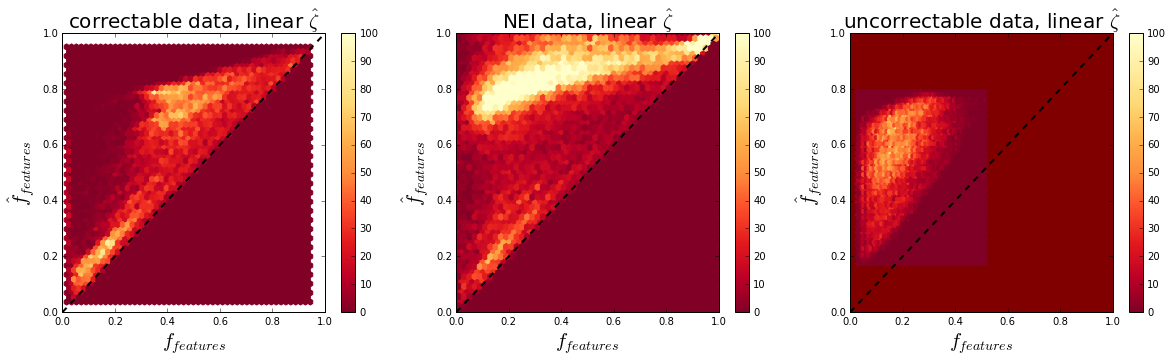

In [32]:
# 2D histogram of new p_features distribution
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(131)
hex1 = ax1.hexbin(old_votes[correctable],new_c, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0,vmax=100)
ax1.set_xlabel(r'$f_{features}$',fontsize=20)
ax1.set_ylabel(r'$\hat f_{features}$',fontsize=20)
cb1 = plt.colorbar(hex1)
ax1.set_title('correctable data, linear $\hat \zeta$',fontsize=20)

# Add the one-to-one line for comparision.
# Upper left = boosted p_features for z > 0.3
# Lower right = depressed p_features for z < 0.3

ax1.plot([0,1],[0,1],color='k',lw=2,ls='--')

# Try it with Mel's new function
ax2 = fig.add_subplot(132)
hex2 = ax2.hexbin(old_votes[nei],new_nei, cmap=plt.cm.YlOrRd_r,gridsize=50,vmax=100)
ax2.set_xlabel(r'$f_{features}$',fontsize=20)
ax2.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
cb2 = plt.colorbar(hex2)
ax2.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax2.set_title('NEI data, linear $\hat \zeta$',fontsize=20)

ax3 = fig.add_subplot(133)
hex3 = ax3.hexbin(old_votes[uncorrectable],new_unc, cmap=plt.cm.YlOrRd_r,gridsize=50,vmin =0, vmax=100)
ax3.set_xlabel(r'$f_{features}$',fontsize=20)
ax3.set_ylabel(r'$\hat f_{features}$',fontsize=20)
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
cb3 = plt.colorbar(hex3)
ax3.plot([0,1],[0,1],color='k',lw=2,ls='--')
ax3.set_title('uncorrectable data, linear $\hat \zeta$',fontsize=20)
ax3.set_axis_bgcolor('#800000')

